Matriz de criterios:
 [[   29.   48732.33   191.       0.83]
 [   17.   60196.12   225.       1.12]
 [   27.   61001.92   207.       0.59]
 [   87.   49922.97   192.       0.38]
 [   49.   43922.23   177.       0.52]
 [   29.   52119.78   190.       0.66]
 [   81.   55239.46   204.       0.45]
 [   35.   52648.4    206.       0.71]
 [   47.   55078.33   216.       0.52]
 [   25.   46988.9    175.       0.54]]


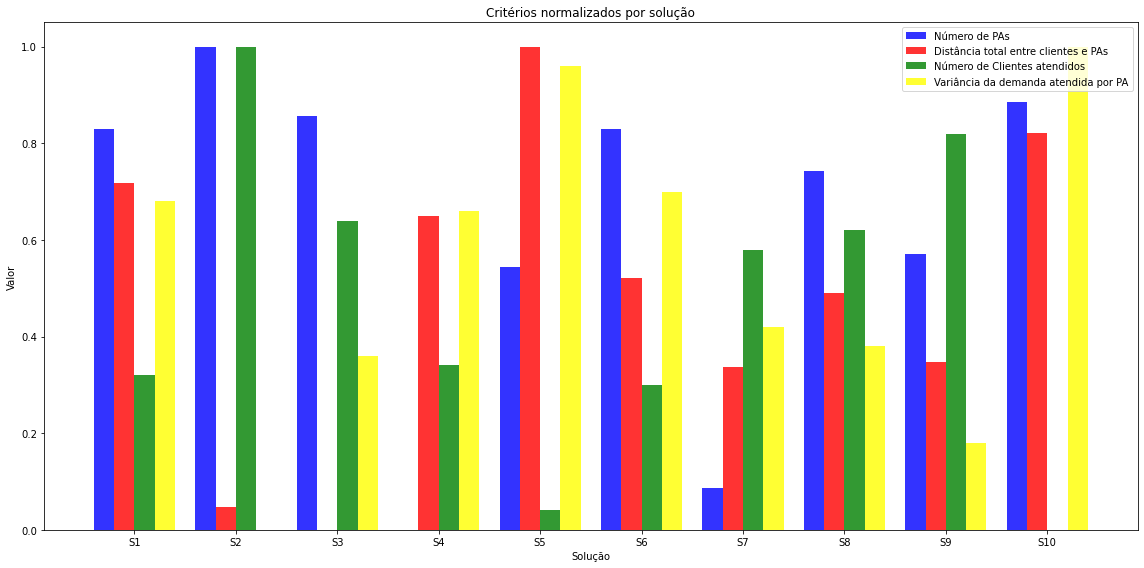

Scores:  [5. 2. 1. 0. 1. 2. 1. 3. 1. 3.]
Ordem de classificacao:  [ 1 10  8  6  2  9  7  5  3  4]
Melhor solucao:  1


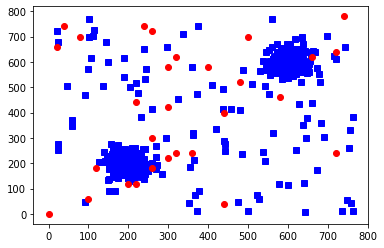

In [2]:
#Os dados utilizados foram salvos da execução da otimização biobjetivo, e podem ser encontrados no link
#https://mega.nz/folder/wol0Bbzb#FgvenkQcnmwhTeeXR3TKdQ
#na pasta Ex2/PW
import numpy as np
import os,sys,math,copy,operator
import igraph
import cairo
import pickle
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

np.set_printoptions(precision=2,suppress=True)

#Plota grafico de barras com valores normalizados dos criterios por solucao
def plotSolCriterios(solCriterios):
    nSol = solCriterios.shape[0]
    nC = solCriterios.shape[1]

    fig, ax = plt.subplots(figsize=(16, 8))
    index = np.arange(nSol)
    bar_width = 0.2
    opacity = 0.8

    namesC = ['Número de PAs', 'Distância total entre clientes e PAs', 'Número de Clientes atendidos', 'Variância da demanda atendida por PA']
    colors= ['blue', 'red', 'green', 'yellow']
    for i in range(nC):
        plt.bar(index + i*bar_width, solCriterios[:,i], bar_width, alpha=opacity, color=colors[i], label=namesC[i])

    plt.xlabel('Solução')
    plt.ylabel('Valor')
    plt.title('Critérios normalizados por solução')
    plt.xticks(index + 1.5*bar_width, getNames(nSol))
    plt.legend()

    plt.tight_layout()
    plt.show()
    
# Plota os clientes e os pontos de acesso utilizados de uma solução
def plotSol(dados):
    P = dados['P']
    pos = dados['ap'] == 1
    x_sol = P[pos]

    plt.plot(dados['C'][:,0],dados['C'][:,1],'bs')
    plt.plot(x_sol[:,0], x_sol[:,1], 'ro')
    plt.show()
    
#Criterios
def nAps(ap):
    return sum(ap)

def distClientes(acp,d):
    return (acp*d).sum()

def nClientes(acp):
    return acp.sum()

def varDemandaAp(acp,cc):
    demanda = np.matmul(acp.transpose(),cc)
    return np.var(demanda)

#Obtem reta y=ax+b
def reta(x,y):
    if (x[1]-x[0] == 0):
        a = 1
    else:
        a = (y[1]-y[0])/(x[1]-x[0])
        
    b = y[1] - a*x[1]
    
    return [a,b]

#Obtem y dados a, b e x
def evaluate(p,x):
    return p[0]*x+p[1]

#Normaliza utilizando uma reta
def normalize(arr,lim):
    return evaluate(reta([min(arr),max(arr)],lim),arr)

#Obtem a matriz de comparacao entre as solucoes
def comparison(alternativas,operation):
    ops = {'>': operator.gt,
           '<': operator.lt,
           '=': operator.eq}
    n=alternativas.shape[0]
    nC=alternativas.shape[1]
    p=np.empty((n,n), dtype=object)          
    for i in range(n):
        for j in range(n):
            if(j!=i):
                p[i,j]=[]
                for z in range(nC):
                    if(ops[operation](alternativas[i,z], alternativas[j,z])):
                        p[i,j].append(z)
    return p

#Obtem a matriz de coeficientes, dada uma matriz de comparacao
def coeficientes(p, pesos):
    n = p.shape[0]
    pcoef=np.empty((n,n))   
    for i in range(n):
        for j in range(n):
            if(p[i,j] != None):
                pcoef[i,j]=sum(pesos[p[i,j]])
    return pcoef

#Calcula os coeficientes de discordancia
def calcDiscord(alternativas,pmenos):
    n = alternativas.shape[0]
    discord=np.empty((n,n))   
    for i in range(n):
        for j in range(n):
            if(i!=j):
                if(len(pmenos[i,j])==0):
                    discord[i,j]=0
                else:
                    discord[i,j]=max(alternativas[j,pmenos[i,j]]-alternativas[i,pmenos[i,j]])
    return discord

#Calcula a matriz adjacente, para plotar o grafo
def adjcMatrix(concord,discord, upperLim, lowerLim):
    n = concord.shape[0]
    adjc=np.empty((n,n))
    for i in range(n):
        for j in range(n):
            if(i!=j and concord[i,j]>upperLim and discord[i,j]<lowerLim):
                adjc[i,j]=1
            else:
                adjc[i,j]=0
    return adjc

#Classifica as solucoes
def classification(adjc):
    scores=adjc.sum(axis=1)
    print("Scores: ", scores)
    classification=np.flip(np.argsort(scores))
    print("Ordem de classificacao: ", classification + 1)
    print("Melhor solucao: ", classification[0] + 1)
    
    return classification[0]

#Nomeia as solucoes
def getNames(n):
    names=[]
    for i in range(n):
        names.append("S{}".format(i+1))
    return names

#Plota o grafo
def plotGraph(adjc):
    g = igraph.Graph.Adjacency((adjc > 0).tolist())
    g.vs["name"] = getNames(len(g.vs))

    visual_style = {}
    visual_style["vertex_size"] = 30
    visual_style["vertex_color"] = ["white"]
    visual_style["vertex_label"] = g.vs["name"]
    visual_style["layout"] = g.layout_circle()
    visual_style["bbox"] = (400, 400)

    igraph.plot(g, **visual_style).show()
    
#Plota os grafos e decide a melhor solucao pelo metodo ELECTRE
def ELECTRE(alternativas,pesos,upperLim,lowerLim):
    pmais=comparison(alternativas,'>')
    pigual=comparison(alternativas,'=')
    pmenos=comparison(alternativas,'<')

    pmaisC=coeficientes(pmais,pesos)
    pigualC=coeficientes(pigual,pesos)
    pmenosC=coeficientes(pmenos,pesos)

    concord=pmaisC+pigualC
    discord=calcDiscord(alternativas,pmenos)

    adjc=adjcMatrix(concord,discord,upperLim,lowerLim)
    plotGraph(adjc)
    
    return classification(adjc)

    
#Retorna a matriz de solucoes X criterios normalizada
def criteriosEscalados(dados):
    alternativas=[]
    for i in range(len(dados)):
        c=[nAps(dados[i]['ap']),distClientes(dados[i]['acp'],dados[i]['d']),nClientes(dados[i]['acp']),varDemandaAp(dados[i]['acp'],dados[i]['cc'])]
        alternativas.append(c)
        
    alternativas=np.array(alternativas)
    print("Matriz de criterios:\n", alternativas)

    alternativas[:,0]=normalize(alternativas[:,0],[1,0])
    alternativas[:,1]=normalize(alternativas[:,1],[1,0])
    alternativas[:,2]=normalize(alternativas[:,2],[0,1])
    alternativas[:,3]=normalize(alternativas[:,2],[1,0])
    
    return alternativas

#Leitura dos dados salvos da otimização
dados=[]
folder = "Ex2/PW" #Caminho relativo da pasta, adaptar de acordo com o local de execucao
files = [f for f in listdir(folder)]

for file in files:
    path = folder + file
    with open(path, 'rb') as handle:
        dados.append(pickle.load(handle))

solCriterios=criteriosEscalados(dados)
plotSolCriterios(solCriterios)
pesos=np.array([0.35,0.2,0.35,0.1])
bestSol=ELECTRE(solCriterios,pesos,0.6,0.4)
plotSol(dados[bestSol])